# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML


%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


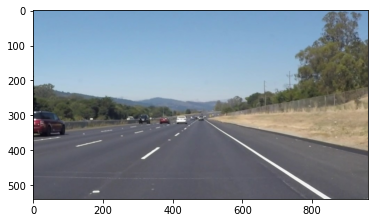

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_line_angle_limit = [-33, -40]
    right_line_angle_limit = [25, 35]

    left_lines = {'x_min': img.shape[1],
                  'y_min': img.shape[0],
                  'x_max': 0,
                  'y_max': 0}
    right_lines = {'x_min': img.shape[1],
                   'y_min': img.shape[0],
                   'x_max': 0,
                   'y_max': 0}
    for line in lines:
        for x1,y1,x2,y2 in line:
            angle = np.rad2deg(np.arctan2(y2-y1, x2-x1))
            if left_line_angle_limit[0] > angle > left_line_angle_limit[1] and x1 < img.shape[1]/2:
                left_lines["x_min"] = min(left_lines["x_min"], x1)
                left_lines["y_min"] = min(left_lines["y_min"], y2)
                left_lines["x_max"] = max(left_lines["x_max"], x2)
                left_lines["y_max"] = max(left_lines["y_max"], y1)
            elif right_line_angle_limit[0] < angle < right_line_angle_limit[1] and x2 > img.shape[1]/2:
                right_lines["x_min"] = min(right_lines["x_min"], x1)
                right_lines["y_min"] = min(right_lines["y_min"], y1)
                right_lines["x_max"] = max(right_lines["x_max"], x2)
                right_lines["y_max"] = max(right_lines["y_max"], y2)
                
    if left_lines["x_max"] > 0:
        cv2.line(img, (left_lines["x_min"], left_lines["y_max"]), (left_lines["x_max"], left_lines["y_min"]), color, thickness)
    if right_lines["x_max"] > 0:
        cv2.line(img, (right_lines["x_min"], right_lines["y_min"]), (right_lines["x_max"], right_lines["y_max"]), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def get_vertices(image: np.ndarray) -> np.ndarray:
    height_limit = 0.6
    width_limit_bottom_min = 0.2
    width_limit_bottom_max = 0.95
    width_limit_middle_min = 0.45
    width_limit_middle_max = 0.55

    return np.array([[(int(image.shape[0]*width_limit_bottom_min), image.shape[0]), 
                      (int(image.shape[1]*width_limit_middle_min), int(image.shape[0]*height_limit)), 
                      (int(image.shape[1]*width_limit_middle_max), int(image.shape[0]*height_limit)), 
                      (int(image.shape[1]*width_limit_bottom_max), image.shape[0])]], dtype=np.int32)

def draw_hough_lines_on_original_image(original_image: np.ndarray, 
                                       img: np.ndarray, 
                                       rho: int, 
                                       theta: float, 
                                       threshold: int, 
                                       min_line_len: int, 
                                       max_line_gap: int) -> np.ndarray:
    """
    `original_image` should be a copy of the original image.
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    draw_lines(original_image, lines)
    return original_image

def apply_line_detection(image: np.ndarray, parameters: dict) -> np.ndarray:
    img = grayscale(np.copy(image))
    img = gaussian_blur(img, parameters["kernel_size"])
    img = canny(img, parameters["low_threshold"], parameters["high_threshold"])
    img = region_of_interest(img, get_vertices(image))
    img = hough_lines(img, 
                      parameters["rho"], 
                      parameters["theta"], 
                      parameters["threshold"], 
                      parameters["min_line_len"], 
                      parameters["max_line_gap"])
    return weighted_img(img, np.copy(image))

def process_image(image):
    canny_low_theshold = 60
    parameters = {"kernel_size": 7,
                  "low_threshold": canny_low_theshold, 
                  "high_threshold": 3*canny_low_theshold,
                  "rho": 3, 
                  "theta": 5*np.pi/180, 
                  "threshold": 10, 
                  "min_line_len": 50, 
                  "max_line_gap": 40}
    img = grayscale(np.copy(image))
    img = gaussian_blur(img, parameters["kernel_size"])
    img = canny(img, parameters["low_threshold"], parameters["high_threshold"])
    img = region_of_interest(img, get_vertices(image))
    try:
        img = hough_lines(img, 
                          parameters["rho"], 
                          parameters["theta"], 
                          parameters["threshold"], 
                          parameters["min_line_len"], 
                          parameters["max_line_gap"])
    except TypeError as e:
        img = np.copy(image)
        print(e)
    return weighted_img(img, np.copy(image))

## Building a Lane Finding Pipeline

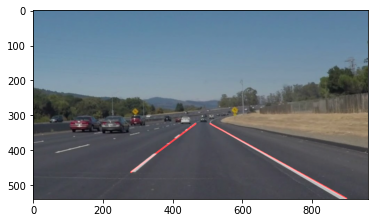

In [4]:
test_images_dir = "test_images"
test_images_output_dir = "test_images_output"

for image_name in os.listdir(test_images_dir):
    image = mpimg.imread(os.path.join(test_images_dir, image_name))
    canny_low_theshold = 50
    parameters = {"kernel_size": 3,
                  "low_threshold": canny_low_theshold, 
                  "high_threshold": 3*canny_low_theshold,
                  "rho": 2, 
                  "theta": 1*np.pi/180, 
                  "threshold": 50, 
                  "min_line_len": 100, 
                  "max_line_gap": 160}
    image_with_lines = apply_line_detection(image, parameters)
    if not os.path.exists(test_images_output_dir):
        os.makedirs(test_images_output_dir)
    plt.imshow(image_with_lines)
    cv2.imwrite(os.path.join(test_images_output_dir, image_name), cv2.cvtColor(image_with_lines, cv2.COLOR_RGB2BGR))

## Test on Videos

## Video 1

In [5]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   8%|▊         | 17/221 [00:00<00:01, 164.44it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 1.69 s, sys: 301 ms, total: 1.99 s
Wall time: 2.83 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Video 2

In [7]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   2%|▏         | 15/681 [00:00<00:04, 145.29it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 5.52 s, sys: 1.06 s, total: 6.58 s
Wall time: 8.91 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Video 3

In [9]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   4%|▍         | 10/251 [00:00<00:02, 92.90it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 3.54 s, sys: 665 ms, total: 4.2 s
Wall time: 5.82 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))